Study the percolation transition of the E-R graph numerically.

- How does the size of the largest connected component scales with the system size at the critical point?
- How does the size of the largest connected component grows with $p$ at the critical point?

Show pictures of the generated graphs both below and above the critical point, and also figures revealing the scaling of the 2 largest connected component at $p_c$.

**SUMMARY**



***Goal***

Our goal is to study the critical behavior of the system at the percolation transition point of the Erdős-Rényi graph numerically. For this, we will investigate the behaviour of the two largest connected components. We will generate samples with fixed average node degree (the critical value) and measure the size of the two largest connected components as a function of the number of nodes or the linking probability. (We will use more samples with the same parameters and we will only use their provided result's average for higher precision.)

***Preliminaries***

Plotting the size of the largest connected component with respect to the average node degree we will see a phase transition, the percolation transition. It is an other way to see this transition, the study of the susceptibility: whether we have a peak, we have a phase transition.

***Core of the project***

We will investigate the dependence of the size of the two largest connected component of an Erdős-Rényi random graph either on the number of nodes and the linking propability at the critical point.

As we will see, these are seemingly scaling functions. We fitted polinomial functions to the data points (using only $x^{\alpha}$ dependence, e.g. not $\sum_{k=1}^{N}A_{k}x^{\alpha_{k}}$, where $A_{k}$-s are some coefficients) and fortunately we were able to reach a good fit in every case. We determined the optimal value of the parameters and their error. Using more samples for the averaging could help reducing the error, but the drawback of this is the running error gets higher and higher.

In [1]:
# Import some packages and functions we need to carry out this project.
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
from ipywidgets import *
from scipy.optimize import curve_fit

***Little examination on the criticality.***

First, let us see the phase transition as the function of the average node degree $\left<k\right>$ . With this process we calculate the critical $\left<k\right>$ value numerically, moreover we will be able to calculate the size of the largest connected component.

Abbreviations:
- ER = Erdős-Rényi,
- AND = average node degree,
- LCC = largest connected component.

In [2]:
N = 1000                                               # number of nodes
samples = 20                                           # number of ER graphs for each case to average
k_values = np.arange(0.05,2.0,0.05)                    # the average node degree - different values to find the critical point
relative_size_of_the_largest_connected_component = []  # list for the relative size of the LCC for every AND value

for k in k_values:
    component_sizes = []                               # for storing all the LCC sizes for all the samples at a given AND value 
    component_sizes.clear()                            # clearing for the sake of safety
    for i in range(0,samples):                         # iterating on all the samples for a given AND value
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1))                                         # generating ER graphs
                                                                                                      # arguments: N, p
        largest_connected_component_size = len(max(nx.connected_components(ER_graph), key = len))/N   # calculating LCC's
                                                                                                      # relative size (*1/N)
        component_sizes.append(largest_connected_component_size)                                      # saving the size  
    relative_size_of_the_largest_connected_component.append(np.mean(component_sizes))                 # averaging the samples
                                                                                                      # at a given AND value for
                                                                                                      # higher precision

In the percolation transition the control parameter is $\left<k\right>$, and the order parameter is $S$. We can introduce the susceptibility $\chi$, which measures how sensitive the system is with respect to small perturbations that try to drive it from one phase to the other. In a phase transition (e.g. percolation) the susceptibility has to have a sharp peak at the critical point. (This statement implicitely requires the existence of the critical point.) $\chi$ can be calculated as: $\chi=\sum_{s_i\neq 𝑠_{max}} s_{i}^{2} p(s)$, where the summation runs over all the components except the largest one, $s_{i}$ denotes the size of component $i$ and $p(s)$ is the component size distribution: $p(s)=N_{s}/N_{comp}$, where $N_{s}$ gives the number of components with size $s$, and $N_{comp}$ is the overall number of components.

In the next cells we will calculate $\chi$ and $S$.

In [3]:
def chi_and_S(network):                                                  # defining a function which calculated chi and S
                                                                         # its imput parameter is a network
    number_of_nodes = network.number_of_nodes()                          # calculating the number of nodes
    components = nx.connected_components(network)                        # grouping with respect to the connected components
                                                                         # "subgraphs"
    component_sizes = [len(c) for c in components]                       # saving their sizes into a list
    component_sizes = sorted(component_sizes,reverse=True)               # descending order
    largest_component_relative_size = component_sizes[0]/number_of_nodes # relative size of the LCC
    chi = 0
                                                                         # calculating chi using the formula above
    if len(component_sizes) > 1:                                         # if there are more than one components (there exist
                                                                         # smaller one(s), too!)
        chi = sum([component_sizes[i]*component_sizes[i] for i in range(1,len(component_sizes))])/(len(component_sizes))
        return chi,largest_component_relative_size
    else:                                                                # only 1 component -> this is the LCC (by definition)
        return chi,largest_component_relative_size

Now we calculate these quantities for an ER graph, numerically. The logic of the procedure is the same as before.

In [4]:
N = 1000
samples = 20
k_values = np.arange(0.05,2.0,0.05)
S_average = []
chi_average = []

for k in k_values:
    S_values = []
    S_values.clear()
    chi_values = []
    chi_values.clear()
    for i in range(0,samples):
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1.0))
        chi, S = chi_and_S(ER_graph)
        S_values.append(S)
        chi_values.append(chi)
    S_average.append(np.mean(S_values))                          # averaging for higher precision
    chi_average.append(np.mean(chi_values))                      # averaging for higher precision

The theoretical solution for $S$ as a function of $\left<k\right>$ can be calculated from the following equation: $S=1-e^{-\left< k\right>S}$. (See Network models / ER model / Giant component (Lecture 6).)

This is an implicite equation for $S$, we will solve it with Newton-Raphson method.

We are trying to find the zeros of $g(\left< k\right>,S)=1-e^{-\left< k\right>S}-S$.



This is a root-finding algorithm of a real-valued function ($g$). It starts with a single-variable function $g$ defined for a real variable $S$, the function's derivative with respect to the 2nd ($S$) argument $g'$, and an initial guess for a root of $S$ (we are using $S=S_{0}=0.5$). If the function satisfies sufficient assumptions (in our case let $|g(\left< k\right>,S)|\leq 0.0000001$) and the initial guess is close, then $S_1=S_0-g(\left< k\right>,S_0) / g'(\left< k\right>,S_0)$ is a better approximation of the root than $S_0$.


The 3 steps to make:
- calculating $g(\left< k\right>,S)$,
- calculating $g'(\left< k\right>,S)$,
- and calculating the zero of the tangent of $g(\left< k\right>,S)$ (see above).

In [5]:
# definition of the 3 steps, the 3 calculations that we have to enumerate
def g_S(k,S):
    return 1-np.exp(-k*S)-S

def g_derivative_S(k,S):
    return k*np.exp(-k*S)-1

def zero_of_g_tangent(k,S,derivative):
    return S-(1-np.exp(-k*S)-S)/derivative;


# calculating the solution of the implicite equation with the Newton-Raphson method
def S_theoretical(k):
    if k <= 1.0:
        return 0
    else:
        S = 0.5
        while (abs(g_S(k,S)) > 0.0000001):
            derivative = g_derivative_S(k,S)
            S = zero_of_g_tangent(k,S,derivative)
        return S
    
S_theoretical = [S_theoretical(k) for k in k_values] # for each AND values

Plotting the relative size of the LCC ($S=s_1/N$) and the susceptibility ($\chi$) as the function of the AND ($\left< k\right>$). We can see that the theoretical curve for $S$ fits well the numerical points, the transition point is at $\left< k\right>=1$. The red points present the susceptibility, whose curve has a "resonance" at around $\left< k\right>=1$, therefore it validates our hypothesis for the critical value of $\left< k\right>=1$.

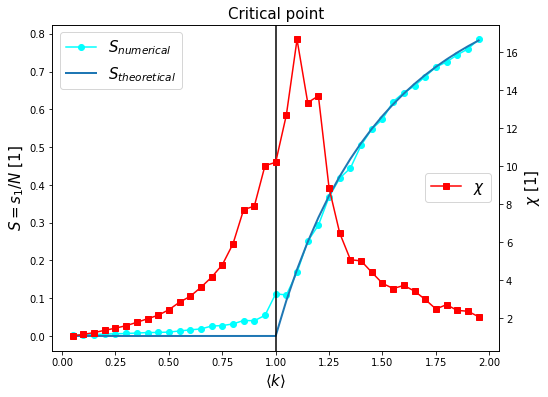

In [6]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()    # using 2 y axes

ax1.plot(k_values,relative_size_of_the_largest_connected_component,'o-',label = '$S_{numerical}$',color='cyan')
ax1.plot(k_values,S_theoretical,'-',label = '$S_{theoretical}$',lw=2)
ax2.plot(k_values,chi_average,'s-',label = '$\chi$',color='r')
ax1.axvline(1,0,1,color='black')

plt.title('Critical point',fontsize=15)
ax1.set_ylabel(r'$S=s_1/N$ [1]',fontsize=15)
ax2.set_ylabel(r'$\chi$ [1]',fontsize=15)
ax1.set_xlabel(r'$\left< k\right>$',fontsize=15)
ax1.legend(loc = 'upper left',fontsize=15)
ax2.legend(loc = 'center right',fontsize=15)
plt.savefig('critical point')
plt.show()

Now, we are confirmed that the transition point is at $\left<k\right>=1$.

Let us rewrite our code to fit the first problem: set $\left<k\right>=1$ and study different sized graphs!

But before doing this, let us do one more thing! Let's show some graphs below and above the critical point!

In [7]:
nodes=200 # the critical p value is 1/(200-1)=1/199

def ER_graphs_to_show(i):
    nx.draw(nx.generators.erdos_renyi_graph(nodes,i*0.2/(nodes-1)),node_size=3)
# If i=1,2,3,4 we are below the critical point, i=5 is corresponding to the critical point, and if i>5 we are above that.

interact(ER_graphs_to_show,i=(1,10,1));

interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

***How does the size of the largest connected component scales with the system size at the critical point?***

Now, we are going to measure the size of the 1st and 2nd largest connected component.

In [83]:
samples = 50
k = 1                            # CRITICAL POINT!
N_values = np.arange(2,1002,20)  # we are studying the N-dependence
                                 # we are going to have (1002-2)/20=50 data points, each is given by the average of 50 samples

av_lcc1_size = []                # we are going to study the size distribution of the LCC and also of the 2nd LCC
av_lcc2_size = []
error_lcc1_size = []             # we are calculating the errors coming from the statistical averaging of the samples 
error_lcc2_size = []
for N in N_values:
    comp1_sizes = []
    comp2_sizes = []
    comp1_sizes.clear()
    comp2_sizes.clear()
    for i in range(0,samples):
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1)); # p as a function of N, in the critical point they are not!)
                                                               # independent variables
        S = [ER_graph.subgraph(c).copy() for c in nx.connected_components(ER_graph)] # S is a list containing the CC-s as graphs
                                                                                     # --> a list of graphs, len(S[i]) gives the
                                                                                     # number of nodes in the i-th graph 
        sizes=[] # the sizes of the connected components in a given ER graph
        for i in range(0,len(S)):
            sizes.append(len(S[i])) 
        sizes=sorted(sizes,reverse=True)   # descending order
        comp1_sizes.append(sizes[0])
        if len(sizes)>1:                   # if there are more than one component present (-> at least one that not the LCC)
            comp2_sizes.append(sizes[1])   # 2nd LCC
        else:                              # if there is only one component present, the LCC
            comp2_sizes.append(0)          # let the size of the 2nd LCC be 0, because it is not present
    av_lcc1_size.append(np.mean(comp1_sizes))   # average
    av_lcc2_size.append(np.mean(comp2_sizes)) 
    error_lcc1_size.append(np.std(comp1_sizes)) # standard deviation -> the error
    error_lcc2_size.append(np.std(comp2_sizes))

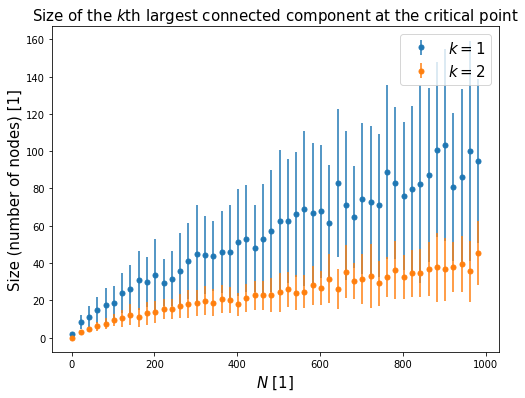

In [84]:
plt.figure(figsize=(8,6))
plt.errorbar(N_values,av_lcc1_size,error_lcc1_size,label='$k=1$',marker='.',ms=10,ls='')
plt.errorbar(N_values,av_lcc2_size,error_lcc2_size,label='$k=2$',marker='.',ms=10,ls='')
plt.xlabel('$N$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('size_N_low_without_fit')
plt.show()

Now, these distributions are seemingly increasing polynomially. Let's fit a polynomial function for each. We have 3 fitting parameters, the most important one is the power.

**!!!** We can see from this figure, that the error is huge comparing to the value, therefore we will fit without the error (fitting with the error was our primary goal but we found ourselves between numerical calculating problems). (In the followings we are commenting the error parts in the fits, in this way it can be seen what one should have been doing for the better results. For reaching this, higher $N$, higher number of samples and denser sampling are required!)

In [85]:
def polynomial(x,a,b,c):  # definition of the function that we want to fit with
    return a*x**b+c

In [86]:
popt1, pcov1 = curve_fit(polynomial, N_values, av_lcc1_size)#, sigma=error_lcc1_size, p0=[0.8,0.66,0.9])
popt2, pcov2 = curve_fit(polynomial, N_values, av_lcc2_size)#, sigma=error_lcc2_size, p0=[0.4,0.66,-0.5])

In [87]:
print('Values of the optimal parameters for the LCC: $a$, $b$, $c$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$, $c$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$, $c$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$, $c$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$, $c$
[0.56179543 0.74198633 2.43560808]
Errors of the optimal parameters for the LCC: $a$, $b$, $c$
[0.26688443 0.06551683 3.61038239]


Values of the optimal parameters for the 2nd LCC: $a$, $b$, $c$
[0.29768136 0.70704883 0.69848639]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$, $c$
[0.12228897 0.05634446 1.3858728 ]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


The parameter $c$ equals 0 in the error, therefore, let us refit, without using $c$.

In [88]:
def polynomial2(x,a,b):
    return a*x**b

popt1, pcov1 = curve_fit(polynomial2, N_values, av_lcc1_size)#, sigma=error_lcc1_size)
popt2, pcov2 = curve_fit(polynomial2, N_values, av_lcc2_size)#, sigma=error_lcc2_size)


print('Values of the optimal parameters for the LCC: $a$, $b$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$
[0.7450392  0.70410438]
Errors of the optimal parameters for the LCC: $a$, $b$
[0.13659793 0.02821665]


Values of the optimal parameters for the 2nd LCC: $a$, $b$
[0.35900284 0.68200403]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$
[0.05648131 0.0242402 ]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In the legend "measured" refers to randomly generated and averaged, from now.

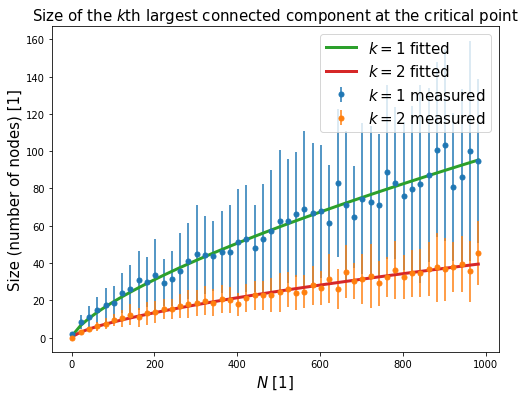

In [91]:
plt.figure(figsize=(8,6))
plt.errorbar(N_values,av_lcc1_size,error_lcc1_size,label='$k=1$ measured',marker='.',ms=10,ls='')
plt.errorbar(N_values,av_lcc2_size,error_lcc2_size,label='$k=2$ measured',marker='.',ms=10,ls='')
plt.plot(N_values,polynomial2(N_values,popt1[0],popt1[1]),label='$k=1$ fitted',lw=3)
plt.plot(N_values,polynomial2(N_values,popt2[0],popt2[1]),label='$k=2$ fitted',lw=3)
plt.xlabel('$N$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('size_N_low')
plt.show()

***CONCLUSION***

The 1st and 2nd LCC's sizes scales with the number of nodes to the power of $\sim 0.67 \approx 2/3$ at the critical point.

In this last fit: $s_1 \sim N^{0.70\pm0.03}$ and $s_2 \sim N^{0.68\pm0.02}$.

In the previous fit: $s_1 \sim N^{0.67\pm0.03}$ and $s_2 \sim N^{0.67\pm0.02}$.

The scaling of the 2 LCC-s are the same in error!

COMMENT: the parameter $a$ (this is the "amplitude" of these power functions) has a non-negligible error, it can be reduced if we sample more densely in $N$ and run the simulation for higher range $N$-s, as well.

Let's see the fit for an interval containing only higher $N$-s.

We are doing the same here as previously but for higher $N$ values and less samples, because the number of samples also increases the running time.

**DO NOT RUN THIS CELL! (IT TAKES A LOT OF TIME)**

In [92]:
#   FROM NOW, WE DO NOT REALLY WANT TO COMMENT EVERLY LINE, BECAUSE BASICALLY WE ARE JUST REPEATING WHAT WE HAVE DONE BEFORE
#   WE WILL COMMENT THE IMPORTANT OR NEW LINES, OBVIOUSLY
#

samples = 15
k = 1
N_values = np.arange(5000,10000,500) # for only (10000-50000)/500=10 sizes!
                                     # (it takes a lot of time for this small amount of graphs, as well)
av_lcc1_size = []
av_lcc2_size = []
error_lcc1_size = []
error_lcc2_size = []
av_lcc1_size.clear()
av_lcc2_size.clear()
error_lcc1_size.clear()
error_lcc2_size.clear()
for N in N_values:
    comp1_sizes = []
    comp2_sizes = []
    comp1_sizes.clear()
    comp2_sizes.clear()
    for i in range(0,samples):
        ER_graph = nx.generators.erdos_renyi_graph(N,k/(N-1));
        S = [ER_graph.subgraph(c).copy() for c in nx.connected_components(ER_graph)] # S is a list containing the CC-s as 
                                                                                     # graphs, len(S[i]) gives the number of
                                                                                     # nodes in the i-th graph 
        sizes=[] # the size of the connected components in a given ER graph
        for i in range(0,len(S)):
            sizes.append(len(S[i])) 
        sizes=sorted(sizes,reverse=True)   
        comp1_sizes.append(sizes[0])
        if len(sizes)>1:
            comp2_sizes.append(sizes[1])
        else:
            comp2_sizes.append(0)
    av_lcc1_size.append(np.mean(comp1_sizes))
    av_lcc2_size.append(np.mean(comp2_sizes))
    error_lcc1_size.append(np.std(comp1_sizes))
    error_lcc2_size.append(np.std(comp2_sizes))

In [93]:
popt1, pcov1 = curve_fit(polynomial2, N_values, av_lcc1_size, p0=[1.3,0.65])#, sigma=error_lcc1_size) # p0 is the list of
popt2, pcov2 = curve_fit(polynomial2, N_values, av_lcc2_size, p0=[0.5,0.65])#, sigma=error_lcc2_size) # guessing values

In [94]:
print('Values of the optimal parameters for the LCC: $a$, $b$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$
[0.06916871 0.96341601]
Errors of the optimal parameters for the LCC: $a$, $b$
[0.09724024 0.1571671 ]


Values of the optimal parameters for the 2nd LCC: $a$, $b$
[1.02309757 0.56164138]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$
[2.24176296 0.2457702 ]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


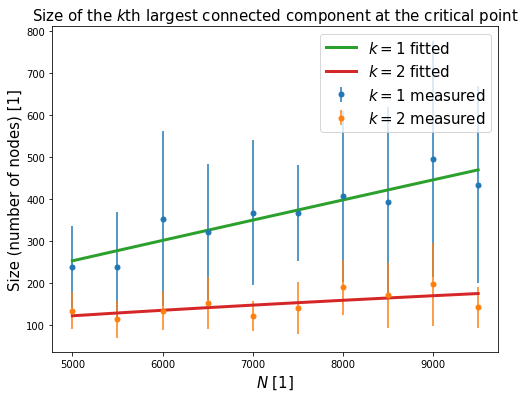

In [95]:
plt.figure(figsize=(8,6))
plt.errorbar(N_values,av_lcc1_size,error_lcc1_size,label='$k=1$ measured',marker='.',ms=10,ls='')
plt.errorbar(N_values,av_lcc2_size,error_lcc2_size,label='$k=2$ measured',marker='.',ms=10,ls='')
plt.plot(N_values,polynomial2(N_values,popt1[0],popt1[1]),label='$k=1$ fitted',lw=3)
plt.plot(N_values,polynomial2(N_values,popt2[0],popt2[1]),label='$k=2$ fitted',lw=3)
plt.xlabel('$N$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('size_N_high')
plt.show()

Scaling behaviour: $s_1 \sim N^{1.0\pm0.2}$ and $s_2 \sim N^{0.6\pm0.2}$. The value corresponding to $s_{1}$ are not equal to the previously got ones in the range of the error, but in the other case we find a good correspondence. (Result of the previous fit for the power corresponding to $s_{1}$ was $0.9\pm0.2$ which is equal to the one got from the lower $N$ case. This shows how unprecise this was, due to the low number of samples and the sparse sampling.) In this case we used only 15 samples and 10 $N$ values, instead of 50, 50, respectively. The reason being is that the running time hardly grows with the $N$ and with the number of samples, as well.

The parameter $a$ has a really high error, it caused by the small number of $N$ values and samples we used.

If we increase the number of samples and $N$ values we are using in the simulation, we will get lower errors for the optimal fitting parameters.

**CONCLUSION**

We were able to detect a power depencence of the size of the 2 LCC-s at the critical point as the function of the AND. The found scaling behaviour is:

size$_{1/2} \sim N_{1/2}^{0.67}$.

***How does the size of the largest connected component grows with $p$ at the critical point?***

Differences between the previous and this task:
- we do not have a list of $N$s, instead a list of $p$s
- argument of 'nx.generators.erdos_renyi_graph(N,p)' were $N$, $p=\left<k\right>/(N-1)$, but now $N=1+\left<k\right>/p$, $p$

In [96]:
samples = 50
k = 1
                                                # we have to apply a little trick because the 1st argument of the
                                                # 'nx.generators.erdos_renyi_graph' function has to be an integer
                                                # first, we generate a list for the N values, but why do we do this? Have we got
                                                # any rights to do that? At first glance, no, because we have to study the
                                                # p-dependence. For the second glance, yes, we can do this, because we are at
                                                # the critical point where p and N are not independent variables! Here <k>=1,
                                                # therefore p = 1/(N-1)
                            
N_values = np.arange(2,1002,20)                 # generating the N-values
p_values = np.array(1/(np.array(N_values)-1))   # from these the p-values
p_values = p_values.tolist()                    # transforming the array to a list (just some formality for a further operation)

av_lcc1_size = []
av_lcc2_size = []
error_lcc1_size = []
error_lcc2_size = []
av_lcc1_size.clear()
av_lcc2_size.clear()
error_lcc1_size.clear()
error_lcc2_size.clear()
for r in range(len(p_values)):                  # running through the corresponding p and N values
    comp1_sizes = []                            # (see the line: 'ER_graph = ...')
    comp2_sizes = []
    comp1_sizes.clear()
    comp2_sizes.clear()
    for i in range(0,samples):
        ER_graph = nx.generators.erdos_renyi_graph(N_values[r],p_values[r]); # N as a function of p!
        S = [ER_graph.subgraph(c).copy() for c in nx.connected_components(ER_graph)]
        
        sizes=[] 
        for j in range(0,len(S)):
            sizes.append(len(S[j])) 
        sizes=sorted(sizes,reverse=True)
        comp1_sizes.append(sizes[0])
        if len(sizes)>1:
            comp2_sizes.append(sizes[1])
        else:
            comp2_sizes.append(0)           
    av_lcc1_size.append(np.mean(comp1_sizes))
    av_lcc2_size.append(np.mean(comp2_sizes))
    error_lcc1_size.append(np.std(comp1_sizes))
    error_lcc2_size.append(np.std(comp2_sizes))

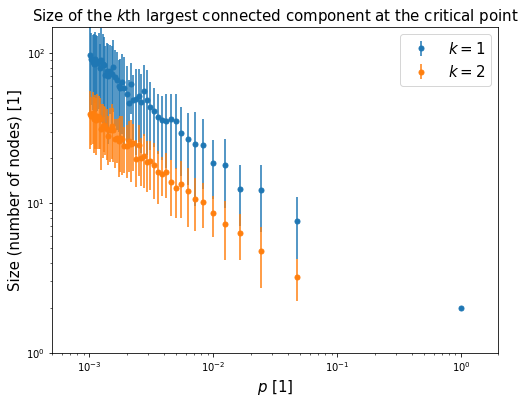

In [97]:
plt.figure(figsize=(8,6))
plt.errorbar(p_values,av_lcc1_size,error_lcc1_size,label='$k=1$',marker='.',ms=10,ls='')
plt.errorbar(p_values,av_lcc2_size,error_lcc2_size,label='$k=2$',marker='.',ms=10,ls='')
plt.xlim(0.5*10**(-3),2*10**0)
plt.ylim(10**0,1.5*10**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('size_p_low_without_fit')
plt.show()

We plotted our results in a double logarithmic plot and we find that the data points are seemingly lying in a line. $\longrightarrow$ Power law distribution.

But before the fitting, we have to get rid of the zero elements of the list containing the sizes of the 2nd LCC-s (the logarithm of 0 is $-\infty$, which causes a little problem).

In [98]:
av_lcc2_size_copy = []                             # "copying" the list containing the sizes of the 2nd LCC-s in such a way that
error_lcc2_size_copy = []                          # we are keeping only the nonzero elements (and the corresponding p-values)
p_values_copy = []

for i in range(len(av_lcc2_size)):
    if av_lcc2_size[i]>0.00001:
        av_lcc2_size_copy.append(av_lcc2_size[i])
        error_lcc2_size_copy.append(error_lcc2_size[i])
        p_values_copy.append(p_values[i])

In [99]:
av_lcc2_size=np.array(av_lcc2_size)                # just some formality, generating arrays from lists
error_lcc2_size=np.array(error_lcc2_size)
p_values=np.array(p_values)
av_lcc2_size_copy=np.array(av_lcc2_size_copy)
error_lcc2_size_copy=np.array(error_lcc2_size_copy)
p_values_copy=np.array(p_values_copy)

In [100]:
def powerlaw(x,a,b,c):                             # definition of the powerlaw function we want to fit
    return a*x**(-b)+c

popt1, pcov1 = curve_fit(powerlaw,p_values,av_lcc1_size)#, sigma=error_lcc1_size)
popt2, pcov2 = curve_fit(powerlaw,p_values_copy,av_lcc2_size_copy)#, sigma=error_lcc2_size_copy) # fitting with using only the
                                                                                                 # nonzero values for the size
                                                                                                 # of the 2nd LCC
print('Values of the optimal parameters for the LCC: $a$, $b$, $c$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$, $c$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$, $c$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$, $c$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$, $c$
[0.65779403 0.71792448 1.93632566]
Errors of the optimal parameters for the LCC: $a$, $b$, $c$
[0.25226637 0.0527468  3.01097524]


Values of the optimal parameters for the 2nd LCC: $a$, $b$, $c$
[0.33906966 0.68790684 0.56011319]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$, $c$
[0.12922573 0.0515375  1.39030086]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Refitting, because $c=0$ in error.

In [101]:
def powerlaw2(x,a,b):
    return a*x**(-b)

popt1, pcov1 = curve_fit(powerlaw2,p_values,av_lcc1_size)#, sigma=error_lcc1_size)
popt2, pcov2 = curve_fit(powerlaw2,p_values_copy,av_lcc2_size_copy)#, sigma=error_lcc2_size_copy)


print('Values of the optimal parameters for the LCC: $a$, $b$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$
[0.81835889 0.68872858]
Errors of the optimal parameters for the LCC: $a$, $b$
[0.1231718  0.02318521]


Values of the optimal parameters for the 2nd LCC: $a$, $b$
[0.39113727 0.66893587]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$
[0.04507147 0.0177687 ]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


The errors are reduced!

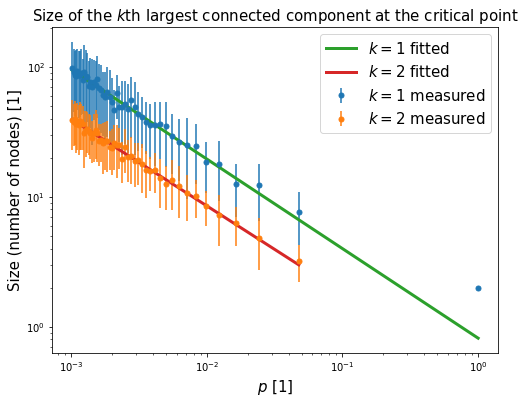

In [102]:
plt.figure(figsize=(8,6))
plt.errorbar(p_values,av_lcc1_size,error_lcc1_size,label='$k=1$ measured',marker='.',ms=10,ls='')
plt.errorbar(p_values_copy,av_lcc2_size_copy,error_lcc2_size_copy,label='$k=2$ measured',marker='.',ms=10,ls='')
plt.plot(p_values,powerlaw2(p_values,popt1[0],popt1[1]),label='$k=1$ fitted',lw=3)
plt.plot(p_values_copy,powerlaw2(p_values_copy,popt2[0],popt2[1]),label='$k=2$ fitted',lw=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('size_p_lowN')
plt.show()

Let's see the fit for an interval containing only higher $N$-s.

****DO NOT RUN THIS CELL! (IT TAKES A LOT OF TIME)****


In [103]:
samples = 15
k = 1
N_values = np.arange(5000,10000,500)
p_values = np.array(1/(np.array(N_values)-1))
p_values = p_values.tolist()

av_lcc1_size = []
av_lcc2_size = []
error_lcc1_size = []
error_lcc2_size = []
av_lcc1_size.clear()
av_lcc2_size.clear()
error_lcc1_size.clear()
error_lcc2_size.clear()
for r in range(len(p_values)):
    comp1_sizes = []
    comp2_sizes = []
    comp1_sizes.clear()
    comp2_sizes.clear()
    for i in range(0,samples):
        ER_graph = nx.generators.erdos_renyi_graph(N_values[r],p_values[r]);
        S = [ER_graph.subgraph(c).copy() for c in nx.connected_components(ER_graph)] 
        
        sizes=[]
        for j in range(0,len(S)):
            sizes.append(len(S[j])) 
        sizes=sorted(sizes,reverse=True)
        comp1_sizes.append(sizes[0])
        if len(sizes)>1:
            comp2_sizes.append(sizes[1])
        else:
            comp2_sizes.append(0)           
    av_lcc1_size.append(np.mean(comp1_sizes))
    av_lcc2_size.append(np.mean(comp2_sizes))
    error_lcc1_size.append(np.std(comp1_sizes))
    error_lcc2_size.append(np.std(comp2_sizes))

In [104]:
av_lcc2_size_copy = []
error_lcc2_size_copy = []
p_values_copy = []
for i in range(len(av_lcc2_size)):
    if av_lcc2_size[i]>0.00001:
        av_lcc2_size_copy.append(av_lcc2_size[i])
        error_lcc2_size_copy.append(error_lcc2_size[i])
        p_values_copy.append(p_values[i])
        
av_lcc2_size=np.array(av_lcc2_size)
error_lcc2_size=np.array(error_lcc2_size)
p_values=np.array(p_values)
av_lcc2_size_copy=np.array(av_lcc2_size_copy)
error_lcc2_size_copy=np.array(error_lcc2_size_copy)
p_values_copy=np.array(p_values_copy)

In [105]:
popt1, pcov1 = curve_fit(powerlaw2,p_values,av_lcc1_size)#, sigma=error_lcc1_size)
popt2, pcov2 = curve_fit(powerlaw2,p_values_copy,av_lcc2_size_copy)#, sigma=error_lcc2_size_copy)

print('Values of the optimal parameters for the LCC: $a$, $b$')
print(popt1)
print('Errors of the optimal parameters for the LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov1)))
print('\n')
print('Values of the optimal parameters for the 2nd LCC: $a$, $b$')
print(popt2)
print('Errors of the optimal parameters for the 2nd LCC: $a$, $b$')
print(np.diag(np.sqrt(pcov2)))

Values of the optimal parameters for the LCC: $a$, $b$
[0.15261902 0.86955082]
Errors of the optimal parameters for the LCC: $a$, $b$
[0.38533142 0.28248019]


Values of the optimal parameters for the 2nd LCC: $a$, $b$
[0.94087679 0.56836079]
Errors of the optimal parameters for the 2nd LCC: $a$, $b$
[1.69708157 0.20232011]


C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\pahok\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


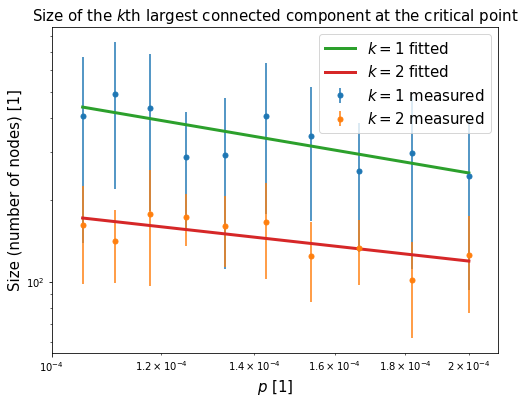

In [106]:
plt.figure(figsize=(8,6))
plt.errorbar(p_values,av_lcc1_size,error_lcc1_size,label='$k=1$ measured',marker='.',ms=10,ls='')
plt.errorbar(p_values_copy,av_lcc2_size_copy,error_lcc2_size_copy,label='$k=2$ measured',marker='.',ms=10,ls='')
plt.xlim(10**(-4),2.1*10**(-4))
plt.plot(p_values,powerlaw2(p_values,popt1[0],popt1[1]),label='$k=1$ fitted',lw=3)
plt.plot(p_values_copy,powerlaw2(p_values_copy,popt2[0],popt2[1]),label='$k=2$ fitted',lw=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$ [1]',fontsize=15)
plt.ylabel('Size (number of nodes) [1]',fontsize=15)
plt.title('Size of the $k$th largest connected component at the critical point',fontsize=15)
plt.legend(loc='upper right',fontsize=15)
plt.savefig('size_p_highN')
plt.show()

Powerlaw behaviour:  
- for this fit: $s_1 \sim p^{-(0.69\pm0.02)}$ and $s_2 \sim p^{-(0.67\pm0.02)}$ for the case with smaller $N$-values and $s_1 \sim p^{-(0.9\pm0.3)}$ and $s_2 \sim p^{-(0.6\pm0.2)}$ for the case with higher $N$-values,
- for the previous fit: $s_1 \sim p^{-(0.66\pm0.03)}$ and $s_2 \sim p^{-(0.67\pm0.02)}$ for the case with smaller $N$-values and $s_1 \sim p^{-(0.9\pm0.3)}$ and $s_2 \sim p^{-(0.8\pm0.1)}$ for the case with higher $N$-values.

These values are equal to the previously got ones in the range of the error. In this case we used only 15 samples and 10 $N$ values, instead of 50, 50, respectively. The reason being is that the running time hardly grows with the $N$ and with the number of samples, as well. (The powers of $p$ in the higher $N$-values case have a really big error, this shows how unprecise this calculation was, due to the low number of samples and the sparse sampling.)

The parameter $a$ has a really high error, it caused by the small number of $N$ values and samples we used (its error is non-negligible in the better-sampled regime, as well).

If we increase the number of samples and $N$ values we are using in the simulation, we will get lower errors for the optimal fitting parameters.

**CONCLUSION**

We were able to detect a powerlaw depencence of the size of the 2 LCC-s at the critical point as the function of the linking probability. The found behaviour is:

size$_{1/2} \sim p_{1/2}^{-0.67}$.

COMMENT: hmm, there is a bit of coincidence, or not? The answer is almost trivial and not, because in the critical point of the ER model, the following equality must hold: $1=\left<k\right>=p(N-1) \approx pN$, which means that $p$ and $N$ are changing inversly! The word almost was there because, we approximated here and this approximation is only valid for $N\gg1$, which is not always the case in our study (we have graphs with $N=$2, 22, 42, 62, ...), but the number of these cases is not big!